In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
from math import sqrt

In [2]:
def load_data_encuesta():
    data_root= "https://raw.githubusercontent.com/matiasch11/menu_semanal/master/Encuesta_vf.csv"
    columns = ['user_id', 'rating', 'comida', 'comidas_id_org']   
    data_encuesta = pd.read_csv(data_root, sep=';', header =0, names=columns, encoding='latin-1', index_col = None)
    return data_encuesta

In [3]:
data = load_data_encuesta()
data.head()

,user_id,rating,comida,comidas_id_org
0,18,3,Ensalada de col con queso,4
1,33,1,Ensalada de col con queso,4
2,63,1,Ensalada de col con queso,4
3,64,2,Ensalada de col con queso,4
4,65,1,Ensalada de col con queso,4


In [4]:
# Verifico que la cantidad de usuarios y comidas sean consistente 
n_users = data.user_id.unique().shape[0]
n_items = data.comida.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

1084 users
407 items


In [5]:
#Creo diccionarios auxiliares
items_id = {}
food = data.comida.unique()
food_id = {}
n = 0
for x in food:
    items_id[x] = n
    food_id[n] = x
    n += 1

In [6]:
items_id['Puchero casero']

110

In [7]:
index = list(range(len(data.index)))

In [8]:
#genero otro id que no tenga saltos como el id original
column_items_id=[]
for x in index:
    column_items_id.append(items_id[data['comida'][x]]) 

In [9]:
data['items_id'] = column_items_id

In [10]:
data.head()

,user_id,rating,comida,comidas_id_org,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [11]:
#Divido la base de datos en train y test
p_train = 0.70 # Porcentaje de train.

data['is_train'] = np.random.uniform(0, 1, len(data)) <= p_train
train, test = data[data['is_train']==True], data[data['is_train']==False]
data = data.drop('is_train', 1)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  29158
Ejemplos usados para test:  12356


In [12]:
ratings = np.zeros((n_users, n_items))
n_rating = len(train) + len(test)
sparsity = n_rating/(ratings.shape[0] * ratings.shape[1])
sparsity *=100
print (sparsity)

9.40959409594096


In [13]:
train.head()

,user_id,rating,comida,comidas_id_org,items_id,is_train
0,18,3,Ensalada de col con queso,4,0,True
1,33,1,Ensalada de col con queso,4,0,True
2,63,1,Ensalada de col con queso,4,0,True
3,64,2,Ensalada de col con queso,4,0,True
4,65,1,Ensalada de col con queso,4,0,True


In [14]:
#Metricas de Evaluacion de Prediccion

In [15]:
class Metrics():
    """
    Implemento las dos métricas más relevante del sistema de recomendación:
        . Recall
        . MAP
    """
    def __init__(self, train_ids, test_ids, recommended_ids):
        
        self.zipped = list(zip(test_ids, train_ids, recommended_ids))
        
    def recall_per_user(self, N, test, recommended, train):
        """
        :param N: numero de recomendaciones
        :param test: lista de comidas por usuario en test
        :param recommended: lista de comidas recomendadas

        :retorna Recall
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
            else:
                rec_true = recommended   
        intersection = len(set(test) & set(rec_true[:N]))
        return intersection / float(np.minimum(N, len(test)))
       
    def recall_at_n(self, topN):
        """
        Calcula el promedio de recall, para la cantidad topN
        """
        out = []
        for k in topN:
            recall = np.mean([self.recall_per_user(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(recall)
            print("recall@%s=%.3f" %(k, recall))
        return out
                                       
    def apk(self, N, test, recommended, train):
        """
        Calcula el promedio de precision para N recomendaciones.

        :param N: numero de recomendaciones
        :param test: lista de comidas por usuario en test
        :param recommended: lista de comidas recomendadas

        :devuelve el promedio de precisión de las N recomendaciones
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
        else:
            rec_true = recommended    
        predicted = rec_true[:N] # top-k predictions

        score = 0.0 
        num_hits = 0.0 

        for i,p in enumerate(predicted):
            if p in test and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits/(i+1.0)

        return score / min(len(test), N)

    def map_at_n(self, topN):
        """
        Calcula la media de precision para topN
        """
        out = []
        for k in topN:
            map_ = np.mean([self.apk(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(map_)
            print("map@%s=%.3f" %(k, map_))
        return out
    
    def metric(self, model, topN):
        """ 
        Retorna la métrica recall y map
        """        
        recall = self.recall_at_n(topk)
        map_ = self.map_at_n(topk)
        return model, recall ,map_  

In [16]:
#Metrica de Evaluacion de Error

In [17]:
class _Error():
    """
    Implemento la métrica de error RMSE
    """
    def __init__(self, y_test, y_recom):
        self.y_test = y_test
        self.y_recom = y_recom
          
    
    def _rmse(self):
        """
        Returna la raiz de la desviación cuadrática Media
        """
        r, c = self.y_test.nonzero()
        p = self.y_recom[r,c]
        t = self.y_test[r,c]
        RMSE = sqrt(np.mean(np.power(p-t, 2.0)))
        
        return print("RMSE=%.3f" %(RMSE))
        

In [18]:
def compare_model_metrics(mod_metric_list, metrics, first, second, third, four, five):
    """ 
    Compara un listado de métricas de Recall y Map para 5 casos distintos de cantidad de items predichos
    """
    
    first = str(first)
    second = str(second)
    third = str(third)
    four = str(four)
    five= str(five)
    
    if metrics== 'Recall':
        vble5 = 'Recall_'+first
        vble10 = 'Recall_'+second
        vble20 = 'Recall_'+third
        vble30 = 'Recall_'+four
        vble50 = 'Recall_'+five
    if metrics== 'Map':
        vble5 = 'Map'+first
        vble10 = 'Map_'+second
        vble20 = 'Map_'+third
        vble30 = 'Map_'+four
        vble50 = 'Map_'+five
    
    plt.style.use('ggplot')
    # crea DataFrames con los datos de métrica
    df_metric_5 = pd.DataFrame(columns=[vble5])
    df_metric_5_index = []
    df_metric_10 = pd.DataFrame(columns=[vble10])
    df_metric_10_index = []
    df_metric_20 = pd.DataFrame(columns=[vble20])
    df_metric_20_index = []
    df_metric_30 = pd.DataFrame(columns=[vble30])
    df_metric_30_index = []
    df_metric_50 = pd.DataFrame(columns=[vble50])
    df_metric_50_index = []
    
    
    for model in mod_metric_list:
        if metrics == 'Recall':
            mod = model[1]
        if metrics == 'Map':
            mod = model[2]
        df_metric_5 = df_metric_5.append({vble5: mod[0]}, ignore_index=True)
        df_metric_5_index.append(model[0])
        df_metric_10 = df_metric_10.append({vble10: mod[1]}, ignore_index=True)
        df_metric_10_index.append(model[0])
        df_metric_20 = df_metric_20.append({vble20: mod[2]}, ignore_index=True)
        df_metric_20_index.append(model[0])
        df_metric_30 = df_metric_30.append({vble30: mod[3]}, ignore_index=True)
        df_metric_30_index.append(model[0])
        df_metric_50 = df_metric_50.append({vble50: mod[4]}, ignore_index=True)
        df_metric_50_index.append(model[0])
    
    # Establece nombres de indices para colocar en el gráfico de barras
    df_metric_5.index = df_metric_5_index
    df_metric_10.index = df_metric_10_index
    df_metric_20.index = df_metric_20_index
    df_metric_30.index = df_metric_30_index
    df_metric_50.index = df_metric_50_index
    
    # Ordena valores para que el mejor modelo aaprezca primero 
    df_metric_5 = df_metric_5.sort_values(vble5, ascending=True)
    df_metric_10 = df_metric_10.sort_values(vble10, ascending=True)
    df_metric_20 = df_metric_20.sort_values(vble20, ascending=True)
    df_metric_30 = df_metric_30.sort_values(vble30, ascending=True)
    df_metric_50 = df_metric_50.sort_values(vble50, ascending=True)
    
    # Crea la figura y un subgráfico por métrica
    f = plt.figure(figsize=(8,len(mod_metric_list*5)))
    axes1 = f.add_subplot(5,1,1)
    axes2 = f.add_subplot(5,1,2)
    axes3 = f.add_subplot(5,1,3)
    axes4 = f.add_subplot(5,1,4)
    axes5 = f.add_subplot(5,1,5)
    
    # grafica Dataframe
    df_metric_5.plot(kind='barh',ax=axes1, title = 'Compare Model Metrics', color='lightcoral')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_10.plot(kind='barh', ax=axes2, color='cornflowerblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_20.plot(kind='barh', ax=axes3, color='goldenrod')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_30.plot(kind='barh', ax=axes4, color='mediumseagreen')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_50.plot(kind='barh', ax=axes5, color='lightblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    
    # indica los valores de resultados en las barras 
     
    for p in axes1.patches:
        if p.get_width()+p.get_x() >0.02:
            x=-30
        else:
            x=-10
        axes1.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(x, 5), textcoords='offset points')

    for p in axes2.patches:
        if p.get_width()+p.get_x() >0.02:
            x=-30
        else:
            x=-10
        axes2.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(x, 5), textcoords='offset points')
    for p in axes3.patches:
        if p.get_width()+p.get_x() >0.02:
            x=-30
        else:
            x=-10
        axes3.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(x, 5), textcoords='offset points')

    for p in axes4.patches:
        if p.get_width()+p.get_x() >0.02:
            x=-30
        else:
            x=-10
        axes4.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(x, 5), textcoords='offset points')
    
    for p in axes5.patches:
        if p.get_width()+p.get_x() >0.02:
            x=-30
        else:
            x=-10
        axes5.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(x, 5), textcoords='offset points')
        
    plt.show()

## Modelos de Popularidad 

In [19]:
class popularity_models(object):
    """
    Generacion de los siguientes modelos de popularidad:
        a) Mayor cantidad de votos positivos en proporción a la cantidad de votos
        b) Mayor puntuación en promedio
    """
    def __init__(self, model, train_df):
        self.model_name = model
        self.train_df = train_df
    
    def positiveRated(self, min_rating=3.0):
        """
        Las comidas con más votos positivos respecto a su cantidad de votos
        """
        mejor_calificados = train[train.rating>=min_rating].groupby('items_id')['user_id'].count()
        calificados = train.groupby('items_id')['user_id'].count()
        return (mejor_calificados/calificados).sort_values(ascending=False) 
        
    def mean_rate(self):
        """
        El promedio más alto de puntuación
        """
        listRated = self.train_df.groupby('items_id')['rating'].apply(list).reset_index()
        mean = listRated.rating.apply(lambda x: np.mean(np.array(x))).sort_values(ascending=False)
        return mean
        
    def train(self, min_rating=3.0):
        """
        Train de modelo de popularidad
        """
        if  self.model_name == 'positiveRated':
            self.model = self.positiveRated(min_rating)
        elif self.model_name == 'mean_rate':
            self.model = self.mean_rate()
        else:
            raise ValueError('%s doesnot exist' % self.model_name)
        
    def predict(self, top_k, verbose=False):
        """
        Returna las top_k recomendaciones 
        """
        return self.model.index.values[:top_k]
    
    def get_name(self, comidas_ids, unique_item_dict):
        """
        Returna el nombre de la recomendaciones
        """
        title = []
        for i, index in enumerate(comidas_ids):
            id_ = index 
            title.append(unique_item_dict[id_])

        print(title)

In [20]:
# Popularidad: Mayor puntuación
puntuacion = popularity_models('mean_rate', train)
puntuacion.train()
puntuacion.model.head()

301    3.846154
169    3.781818
3      3.760000
285    3.714286
247    3.680000
Name: rating, dtype: float64

In [21]:
puntuacion.predict(10)

array([301, 169,   3, 285, 247, 311, 401, 302,  32, 130])

In [22]:
puntuacion.get_name(puntuacion.predict(10), food_id)

['Lasaña Boloñesa', 'Puré de patata con zanahoria', 'Ensalada con tomates cherry', 'Ñoquis con espinacas', 'Pizza Napolitana tradicional', 'Pasta fresca casera', 'Huevos revueltos con tomate', 'Canelones de carne picada y Bechamel', 'Ensaladilla rusa para el verano', 'Canelones de choclo']


In [23]:
# Evaluación de Resultados
topk = [5, 10, 20, 30, 50]
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: puntuacion.predict(np.max(topk))).reset_index()
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****MAP_Recall*****')
puntuacion_m_r = m.metric('puntuacion', topk)

*****MAP_Recall*****
recall@5=0.020
recall@10=0.024
recall@20=0.060
recall@30=0.086
recall@50=0.146
map@5=0.009
map@10=0.007
map@20=0.010
map@30=0.012
map@50=0.015


In [24]:
# Popularidad: Porporcionalmente más positivo
positive = popularity_models('positiveRated', train)
positive.train()
positive.model.head()

items_id
401    0.972973
121    0.965517
355    0.947368
105    0.946429
169    0.945455
Name: user_id, dtype: float64

In [25]:
positive.predict(10)

array([401, 121, 355, 105, 169, 131,  32,   3, 130, 101])

In [26]:
# Evalucion de Resultados
topk = [5, 10, 20, 30, 50]
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: positive.predict(np.max(topk))).reset_index()
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall_Map*****')
positive_m_r = m.metric('positive', topk)

*****Recall_Map*****
recall@5=0.033
recall@10=0.036
recall@20=0.064
recall@30=0.093
recall@50=0.167
map@5=0.015
map@10=0.011
map@20=0.013
map@30=0.016
map@50=0.020


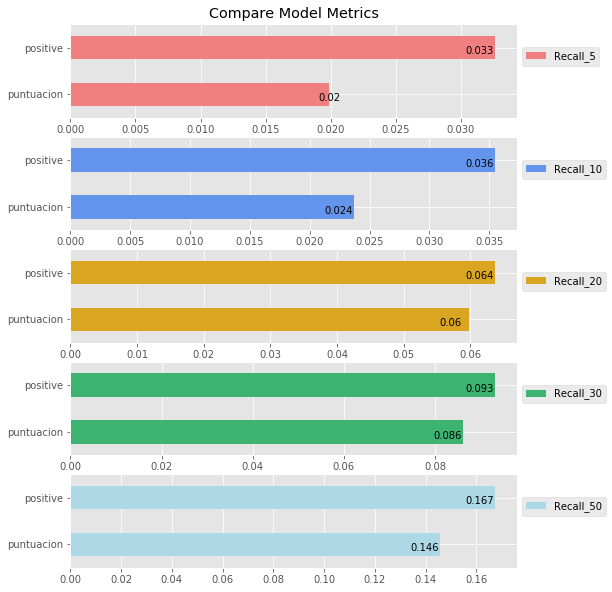

In [27]:
compare_model_metrics([puntuacion_m_r, positive_m_r], 'Recall', 5, 10, 20, 30, 50)

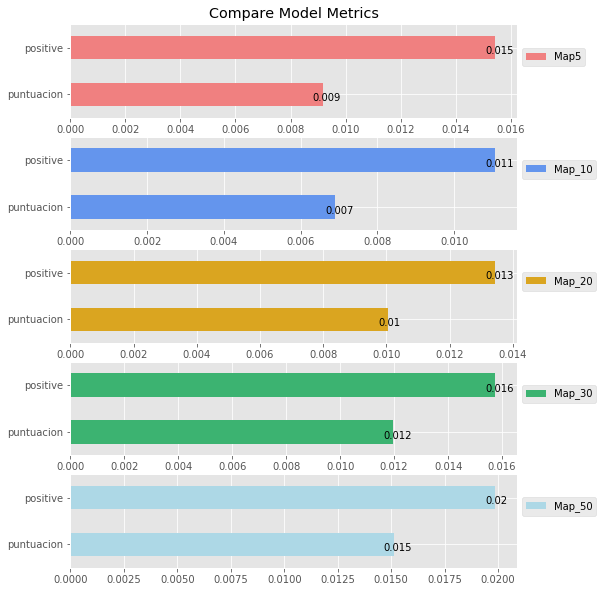

In [28]:
compare_model_metrics([puntuacion_m_r, positive_m_r], 'Map',5, 10, 20, 30, 50)

### MODELOS DE COOCURRENCIA

In [29]:
#Verifico gráficamente si se observa alguna relación entre lo que gusta y entre lo que no gusta 
data_top=(data[data.rating>2])
data_untop=(data[data.rating<=2])

In [30]:
foodPerUser1 = (data_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [31]:
# Matriz de coocurrencia de los que le gustan
coMatrix_top = np.zeros((n_items, n_items))
for food in foodPerUser1.values():
    for x in food:
        coMatrix_top[x, food] += 1

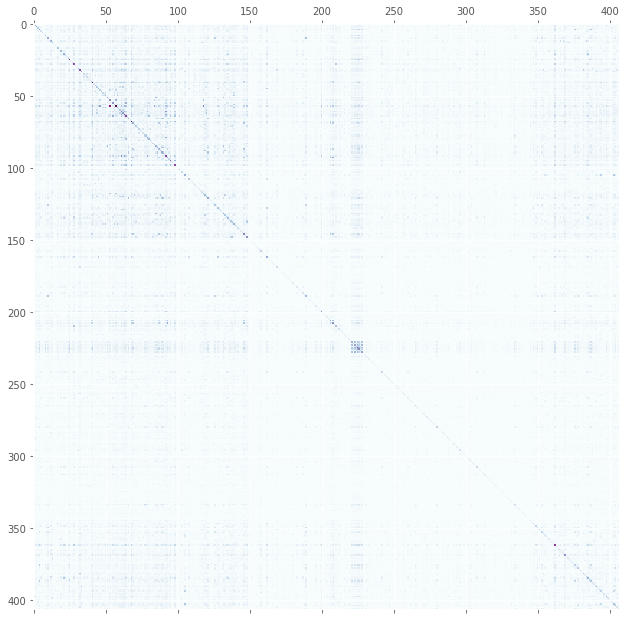

In [32]:
plt.matshow(coMatrix_top, fignum=1000,  cmap=plt.cm.BuPu)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [33]:
foodPerUser2 = (data_untop.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [34]:
# Matriz de coocurrencia de los que NO le gustan
coMatrix2 = np.zeros((n_items, n_items))
for food in foodPerUser2.values():
    for x in food:
        coMatrix2[x, food] += 1

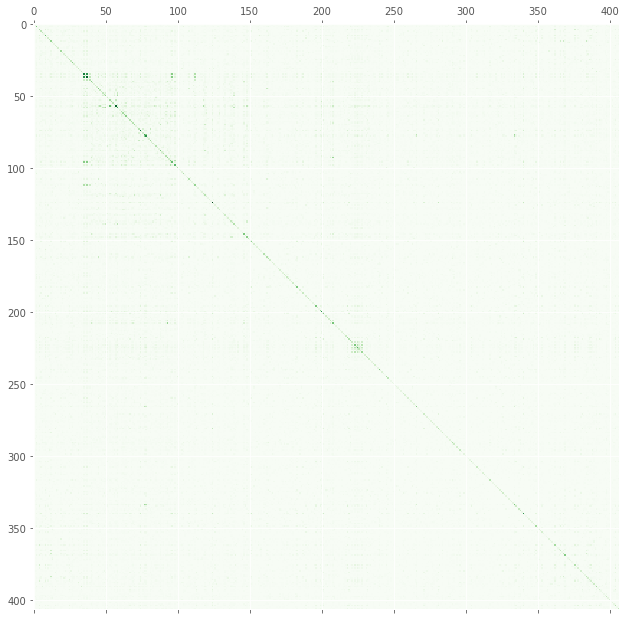

In [35]:
plt.matshow(coMatrix2, fignum=1000, cmap=plt.cm.Greens)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

## Ntop similarity

In [36]:
train_top=(train[train.rating>2])

In [37]:
foodPerUser = (train_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [38]:
coMatrix_top_train = np.zeros((n_items, n_items))
for food in foodPerUser.values():
    for x in food:
        coMatrix_top_train[x, food] += 1

In [39]:
coMatrix_top_train

array([[119.,  11.,  19., ...,  13.,   8.,   1.],
       [ 11.,  73.,   7., ...,   4.,   2.,   0.],
       [ 19.,   7., 121., ...,   3.,   0.,   0.],
       ...,
       [ 13.,   4.,   3., ..., 104.,   3.,  19.],
       [  8.,   2.,   0., ...,   3.,  35.,   1.],
       [  1.,   0.,   0., ...,  19.,   1.,  48.]])

In [40]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Retorna los ntop más similares según la matriz coocurrencia
    """
    similarItems = coocurrance[item_id, :]
    mostSimilar = np.argsort(similarItems)[::-1]
    mostSimilar = mostSimilar[1:ntop+1]
    

    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [41]:
co_occurrance_similarity(122, coMatrix_top_train, 10)

array([[ 31.,  21.],
       [125.,  16.],
       [388.,  14.],
       [ 41.,  10.],
       [391.,  10.],
       [ 32.,   9.],
       [ 68.,   9.],
       [ 92.,   9.],
       [ 64.,   8.],
       [225.,   8.]])

In [42]:
column_items_id[122]

0

In [43]:
FoodId = 1
Ntop = 5
print('Para el item "%s" top-%s recomendaciones son:' % (food_id[FoodId], Ntop))

similarItems = co_occurrance_similarity(FoodId, coMatrix_top_train, Ntop)

for r in similarItems:
    print(int(r[0]), food_id[int(r[0])], r[1])

Para el item "Ensalada de tomate y pimiento asado" top-5 recomendaciones son:
398 Tortilla de Pimientos y Cebolla 28.0
288 Canelones con Verduras 24.0
362 Verduras salteadas con soja 20.0
57 Chuletas de cerdo con salsa mostaza 20.0
53 Chuletas de cerdo a la cerveza 20.0


In [44]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Devuelve la lista ntop recomendacciones, en base a un items_id y una matriz de coocurrencia
    
    """
    
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    out = sorted_list.values[:ntop, 0]
    return out
    

In [45]:
Ntop = 200

In [46]:
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix_top_train, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[92.0, 63.0, 41.0, 226.0, 223.0, 95.0, 64.0, 6..."
1,1,"[61.0, 226.0, 228.0, 223.0, 92.0, 225.0, 95.0,..."
2,2,"[61.0, 41.0, 228.0, 92.0, 225.0, 68.0, 98.0, 6..."
3,3,"[61.0, 226.0, 63.0, 79.0, 223.0, 41.0, 228.0, ..."
4,4,"[57.0, 225.0, 226.0, 223.0, 228.0, 221.0, 33.0..."


In [47]:
topk = [5, 10, 20, 30, 50]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall_Map*****')
matriz_coocurrencia_m_r = m.metric('coocurrencia', topk)

*****Recall_Map*****
recall@5=0.214
recall@10=0.209
recall@20=0.292
recall@30=0.383
recall@50=0.489
map@5=0.259
map@10=0.191
map@20=0.191
map@30=0.206
map@50=0.219


In [48]:
testUsersGrouped['items_id'][10]

[25, 40, 63, 95, 146, 222, 225, 226, 277, 363, 378, 402]

##  Matriz de similaridad de Jaccard similarity

In [49]:
jaccard = np.zeros((n_items, n_items))
for i, row in enumerate(coMatrix_top_train):
    if row[i]!=0: 
        jaccard[i,:] = row/(row[i]+np.diag(coMatrix_top_train)-row)
    else: 
        for j in np.arange(n_items):
            if coMatrix_top_train[j,j]==0:
                jaccard[i,j] = 1.0
            else: 
                jaccard[i,j] = 0.0

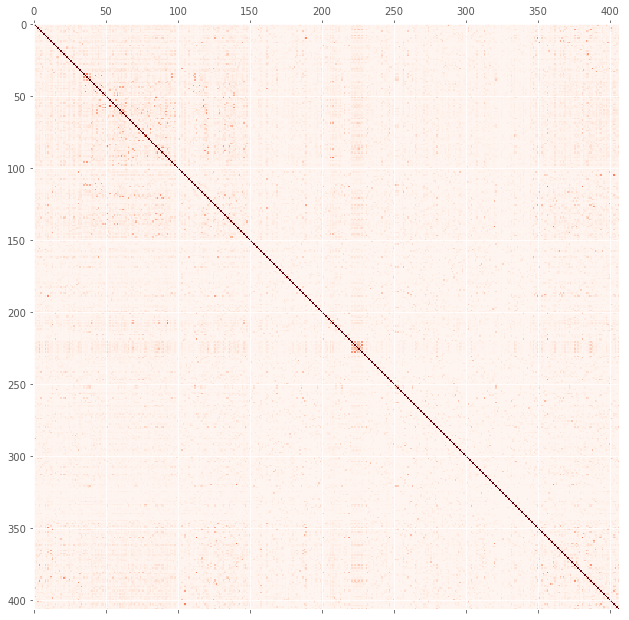

In [50]:
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.Reds)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [51]:
Ntop = 200
# Calculo de predicciones con Jaccard
predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, jaccard, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[223.0, 85.0, 51.0, 132.0, 58.0, 50.0, 92.0, 5..."
1,1,"[223.0, 228.0, 85.0, 51.0, 132.0, 50.0, 56.0, ..."
2,2,"[228.0, 51.0, 85.0, 132.0, 58.0, 136.0, 221.0,..."
3,3,"[77.0, 78.0, 61.0, 351.0, 13.0, 227.0, 224.0, ..."
4,4,"[223.0, 228.0, 221.0, 88.0, 57.0, 33.0, 226.0,..."


In [52]:
topk = [5, 10, 20, 30, 50]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall_Map*****')
jaccard_m_r = m.metric('jaccard',topk)

*****Recall_Map*****
recall@5=0.237
recall@10=0.238
recall@20=0.359
recall@30=0.482
recall@50=0.613
map@5=0.406
map@10=0.312
map@20=0.324
map@30=0.343
map@50=0.359


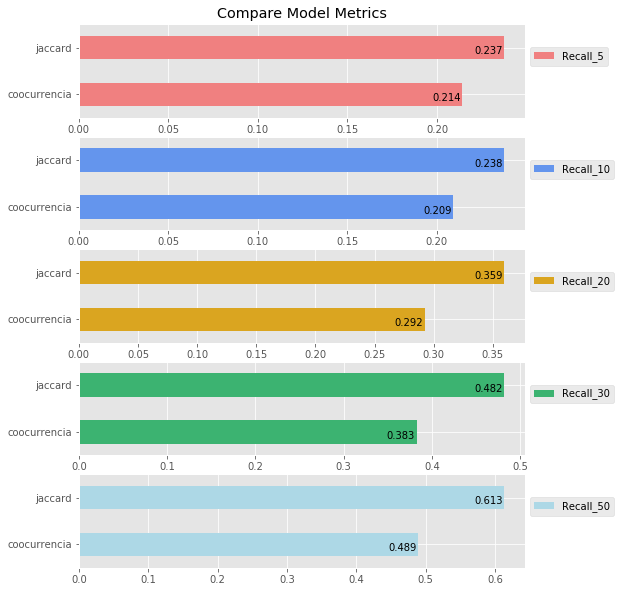

In [53]:
compare_model_metrics([matriz_coocurrencia_m_r, jaccard_m_r], 'Recall',5, 10, 20, 30, 50)

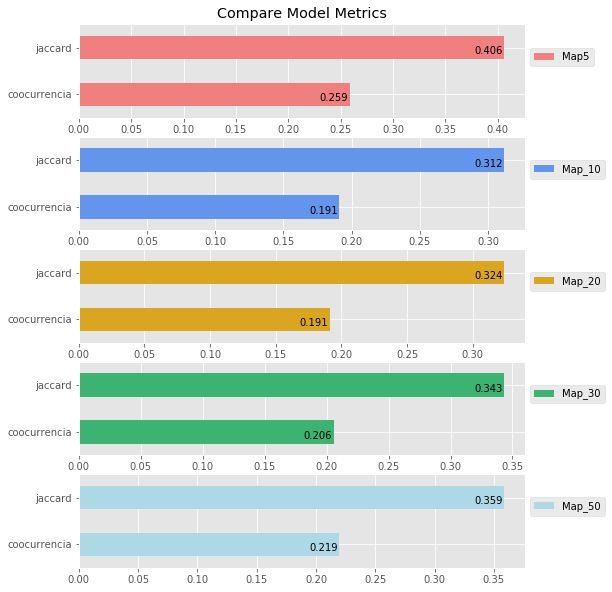

In [54]:
compare_model_metrics([matriz_coocurrencia_m_r, jaccard_m_r], 'Map',5, 10, 20, 30, 50)

# Recomendaciones basadas en Filtrado colaborativo

In [55]:
uMatrixTraining = np.zeros((n_users, n_items)) # Matriz de utilidad
for row in train.values[:,0:5]:
    user = row[0]-1
    item = row[4]
    rating = row[1]
    uMatrixTraining[user, item] = rating

In [56]:
uMatrixTesting = np.zeros((n_users, n_items)) # utility matrix
for row in test.values[:,0:5]:
    user = row[0]-1
    item = row[4]
    rating = row[1]
    uMatrixTesting[user, item] = rating

In [57]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calcula la distancia coseno a lo largo de las fila para una matriz de usuarios y a lo largo de columnas para una matriz de items.
    
    Returna una matriz cuadrada de las similitudes
    """
    if kind == 'user':
        sim = ratings.dot(ratings.T)+epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings)+epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


USER - USER

In [58]:
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

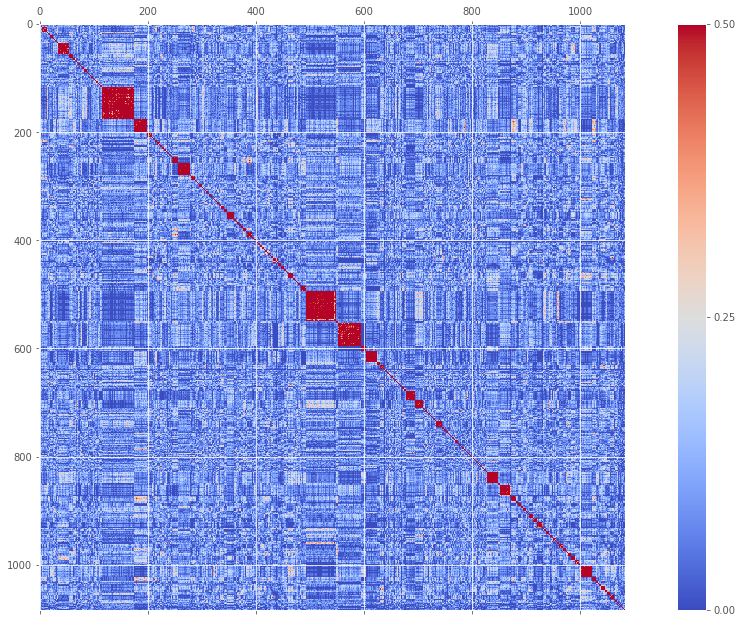

In [59]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [60]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

### Item-Item

In [61]:
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

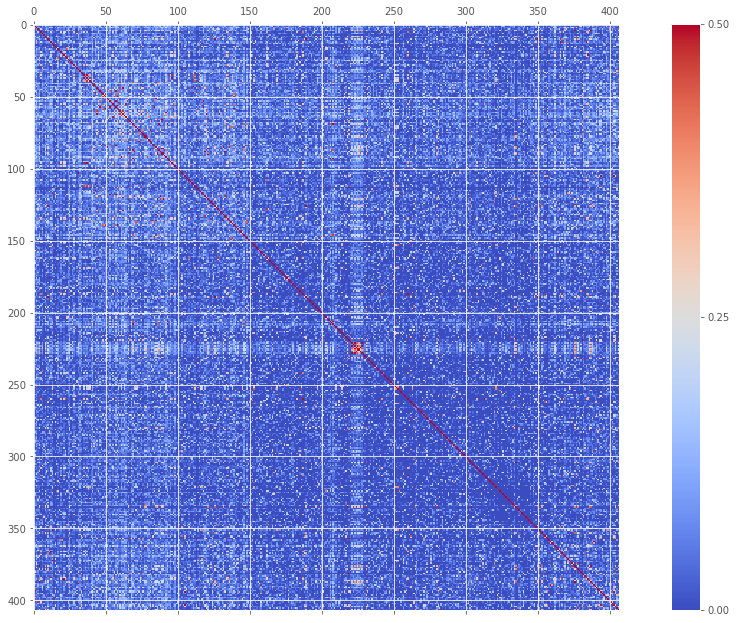

In [62]:
cax = plt.matshow(itemSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [63]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)/np.array([np.abs(itemSimilarity).sum(axis=1)])

In [64]:
query_Id = 300
print("Selecccionado el item '%s'" % food_id[query_Id])

queryAnswer = np.argsort(itemSimilarity[query_Id,:])[::-1][1:]

Ntop = 10
print("Los %d comidas más similares son:" %Ntop)
printAnswer = queryAnswer[0:Ntop]
for answerId in printAnswer:
    print(food_id[answerId]+", con una similaridad del %.2f" %itemSimilarity[query_Id, answerId])

Selecccionado el item 'Raviolis rellenos de setas'
Los 10 comidas más similares son:
Puré de coliflor con queso, con una similaridad del 0.18
Puré de boniato, con una similaridad del 0.17
Ensalada de pasta integral con verduras, con una similaridad del 0.17
Pizza de polenta sin gluten y vegana, con una similaridad del 0.16
Secreto al horno, con una similaridad del 0.16
Estofado de cerdo con manzanas, con una similaridad del 0.15
Estofado de cerdo con champiñones, con una similaridad del 0.14
Ensalada césar con pollo empanado, con una similaridad del 0.13
Ragout de Ternera, con una similaridad del 0.13
Tortilla de brócoli y queso, con una similaridad del 0.13


In [65]:
itemItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>=2.0])
    print("Items recomendados: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 890
Items: 
['Ensalada de repollo y zanahoria', 'Muslitos de pollo en salsa', 'Alambre de res con champiñones', 'Guiso de pollo y setas', 'Salchichas Encebolladas', 'Pollo Empanado al Horno', 'Ensalada de alubias blancas', 'Espaguetis con salchichas y tomate', 'Risotto de setas y pollo', 'Revuelto de patatas con jamón ibérico']
Items recomendados: 
['Pizza con piña hawaiana', 'Patatas al vapor', 'Revuelto de patatas con jamón ibérico', 'Espagueti con pollo y champiñones', 'Puré de patata sin lactosa', 'Ensalada de alubias blancas', 'Calamares a la andaluza', 'Pizza de atún', 'Ensalada de rúcula y queso parmesano', 'Guiso de pollo y setas']
******
User 480
Items: 
['Ensalada con tomates cherry', 'Ensaladilla rusa para el verano', 'Quinoa con calabacín', 'Espaguetis integrales con verduras', 'Puré de Arvejas o Guisantes', 'Revuelto de berenjena']
Items recomendados: 
['Pizza con piña hawaiana', 'Espaguetis integrales con verduras', 'Pastel de champiñones', 'Espaguetis Gratina

In [66]:
userItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Items informados: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>=2.0])
    print("Items recomendados: ")
    recom = userItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 188
Items informados: 
['Ensalada de manzana verde con apio', 'Ensalada de trigo con verduras', 'Ensaladilla de remolacha', 'Ensalada de rábanos', 'Croquetas de ternera guisada', 'Butifarra al horno con patatas', 'Chorizo con papas', 'Merluza rebozada', 'Noodles con Pollo', 'Ravioles cuatro quesos', 'Croquetas de brócoli', 'Tortilla de Pimientos y Cebolla']
Items recomendados: 
['Merluza rebozada', 'Salmón en salsa de queso', 'Carne en salsa fácil', 'Chuletas de cerdo con salsa mostaza', 'Ensalada de maíz y aguacate', 'Croquetas de ternera guisada', 'Estofado de ternera al vino tinto', 'Chuletas de cerdo a la cerveza', 'Redondo de Ternera con Setas', 'Verduras salteadas con soja']
******
User 251
Items informados: 
['Redondo de Ternera con Setas', 'Alambre de res con champiñones', 'Ternera asada al horno', 'Pechugas de pollo a la plancha', 'Coles de bruselas al horno con miel', 'Pollo rústico al horno', 'Pollo con verduras asadas', 'Matambre arrollado al horno', 'Puré de pa

In [67]:
user_item_error = _Error(userItemCFpredictions, uMatrixTesting)
user_item_error._rmse()

RMSE=0.527


In [68]:
item_item_error = _Error(itemItemCFpredictions, uMatrixTesting)
item_item_error._rmse()

RMSE=0.539


In [69]:
itemItemCFpredictions_sorted = np.argsort(itemItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: itemItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 30, 50]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall_Map*****')
item_item_m_r = m.metric('itemitem',topk)

*****Recall_Map*****
recall@5=0.407
recall@10=0.391
recall@20=0.497
recall@30=0.574
recall@50=0.669
map@5=0.468
map@10=0.397
map@20=0.402
map@30=0.418
map@50=0.433


In [70]:
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 30, 50]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall_Map*****')
user_item_m_r = m.metric('useritem',topk)

*****Recall_Map*****
recall@5=0.342
recall@10=0.304
recall@20=0.418
recall@30=0.509
recall@50=0.598
map@5=0.303
map@10=0.241
map@20=0.259
map@30=0.278
map@50=0.292


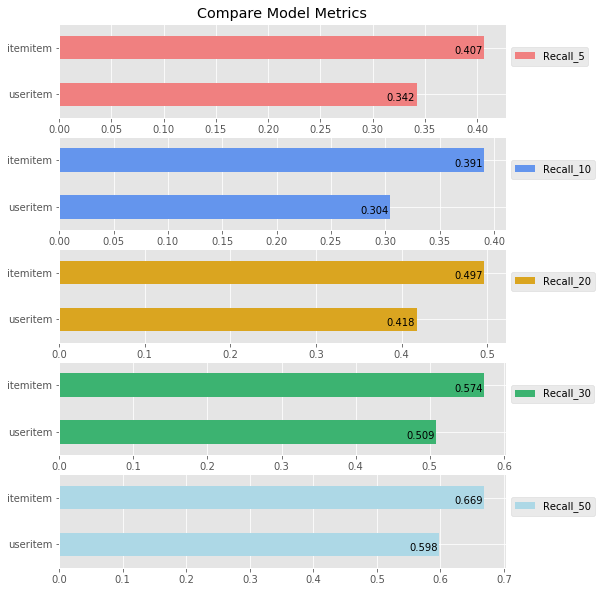

In [71]:
compare_model_metrics([item_item_m_r, user_item_m_r], 'Recall',5, 10, 20, 30, 50)

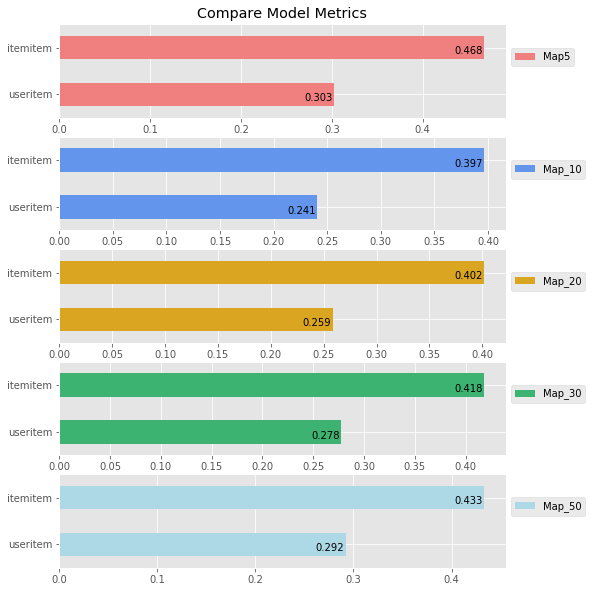

In [72]:
compare_model_metrics([item_item_m_r, user_item_m_r], 'Map',5, 10, 20, 30, 50)

# Comparación de Todas las métricas

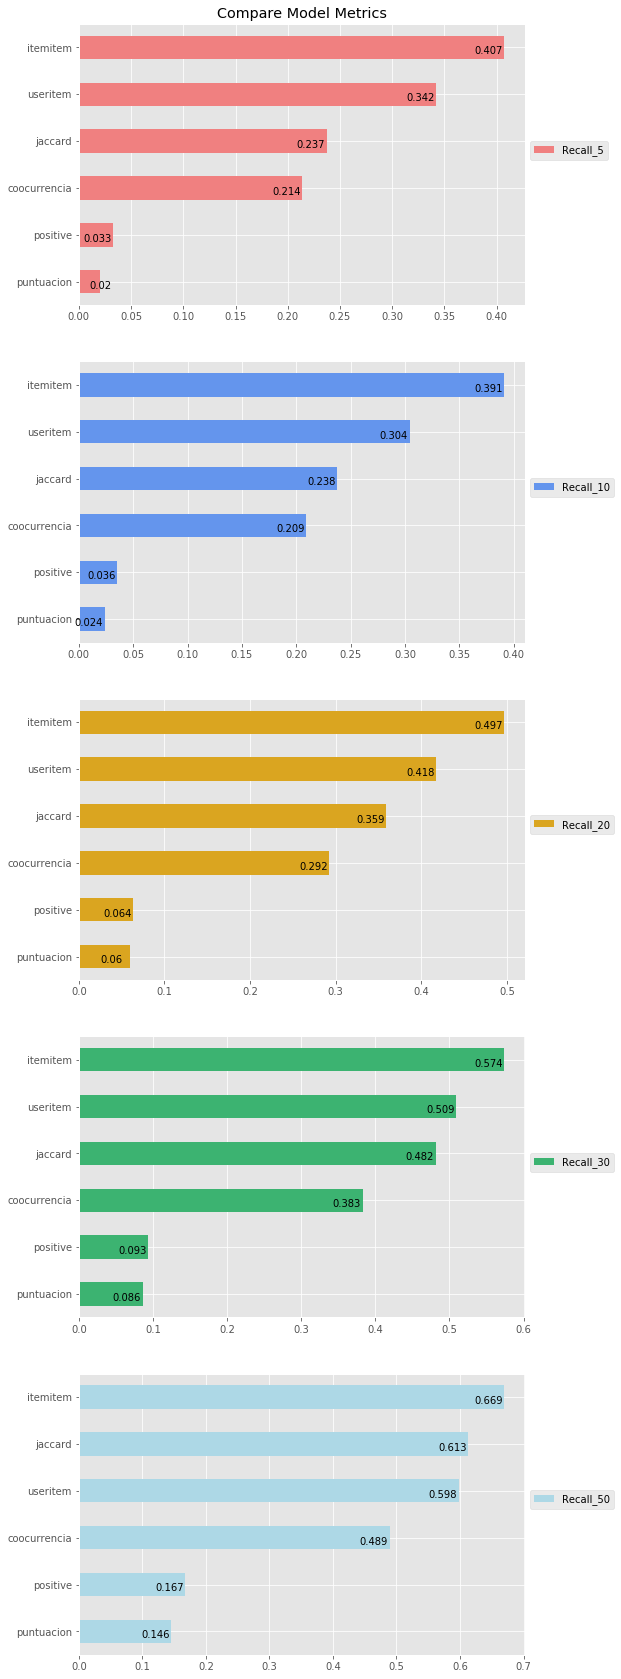

In [73]:
compare_model_metrics([puntuacion_m_r, positive_m_r,matriz_coocurrencia_m_r, jaccard_m_r, item_item_m_r, user_item_m_r], 'Recall',5, 10, 20, 30, 50)

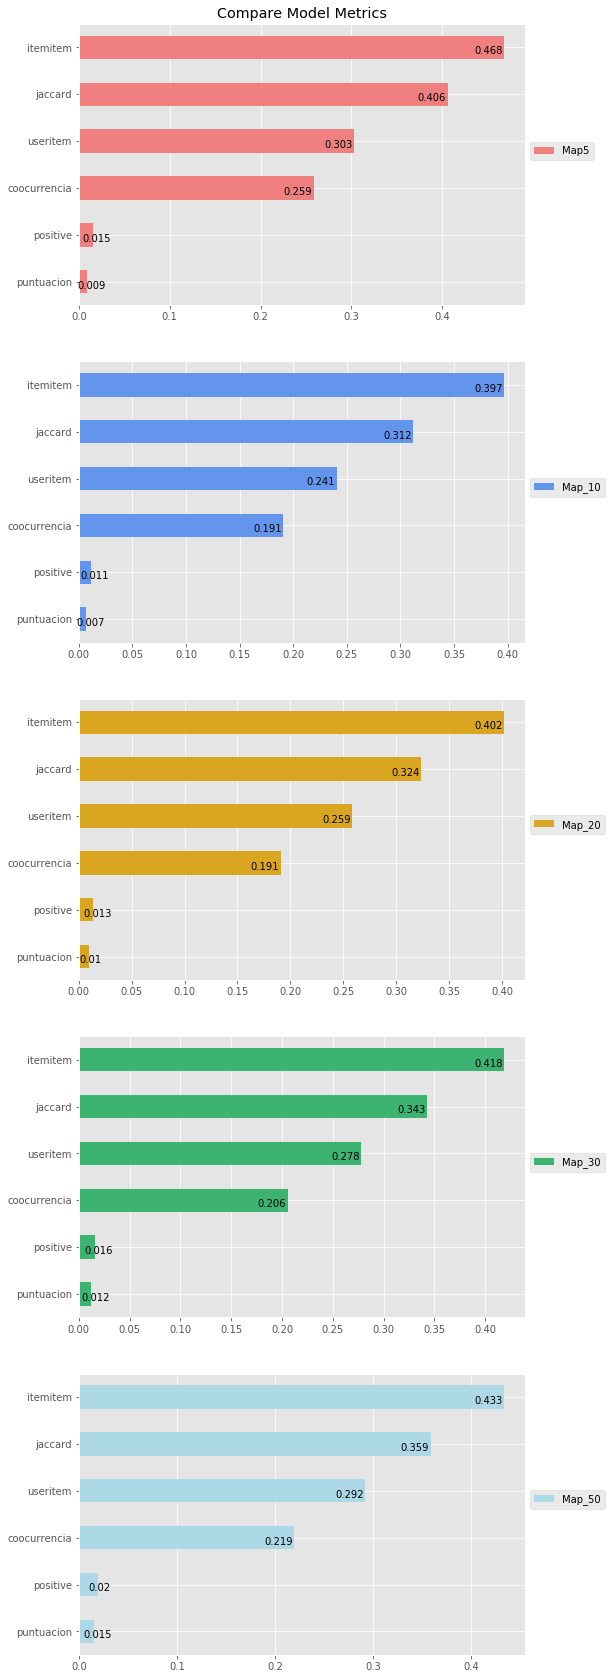

In [74]:
compare_model_metrics([puntuacion_m_r, positive_m_r,matriz_coocurrencia_m_r, jaccard_m_r, item_item_m_r, user_item_m_r], 'Map',5, 10, 20, 30, 50)